# Train model

Train and fine-tune a headless MobileNet V3 on a target image dataset directory

## Config

In [41]:
import tensorflow as tf
from tensorflow.keras import Model, Sequential
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import RandomRotation, RandomFlip, RandomZoom, Dropout, Dense, Input
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.losses import CategoricalCrossentropy
import matplotlib.pyplot as plt
import os
from pathlib import Path
import logging
import pandas as pd
import numpy as np
import sqlalchemy as sqa
from typing import Callable

logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger.propagate = False

os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['font.size'] = 12


In [42]:
# PARAMETERS
# Model Parameters
image_size = (224, 224)
batch_size = 16
dropout_rate = 0.2
shuffle_buffer = 5000

epochs = {
    'top_layer': 500,
    'fine_tuning': 500
}

learning_rates = {
    'top_layer': 0.0001,
    'fine_tuning': 0.000005
}

fine_tune_unfreeze_frac = 0.3


# Data parameters
db_container = "metadata_db"
db_user = "pguser"
db_password = "pgpassword"
db_port = 5432
db_database = "metadata"
db_prefix = "postgresql"

class_weights = {} # TODO

metadata_tbl = "base_images"
datasets_tbl = "datasets"
dataset_img_tbl = "dataset_images"

dataset_name = "test_multi_example"

In [43]:
db_con_str = f"{db_prefix}://{db_user}:{db_password}@{db_container}:{db_port}/{db_database}"
db_engine = sqa.create_engine(db_con_str)

input_shape = (*image_size, 3)

In [44]:
with db_engine.connect() as con:
    df_dataset = pd.read_sql_query(f"""
                                   SELECT * FROM {datasets_tbl}
                                   WHERE name = '{dataset_name}'
                                   """, con, index_col='name')
    df_imgs = pd.read_sql_query(f"""
                                SELECT * FROM {dataset_img_tbl}
                                LEFT JOIN {metadata_tbl} ON {dataset_img_tbl}.image_name = {metadata_tbl}.image_name
                                WHERE dataset_name = '{dataset_name}'
                                """
                                , con, index_col='image_name')
    
ds_config = df_dataset.loc[dataset_name].to_dict()
ds_config['has_test'] = ds_config['test_frac'] > 0
ds_config['has_val'] = ds_config['validation_frac'] > 0
ds_config

{'target_dir': '/home/code/datasets/pipeline_v1/test_multi_dataset',
 'description': 'First example with 50 values from each class and multiclass labeling',
 'validation_frac': 0.2,
 'test_frac': 0.0,
 'label_method': 'MULTI',
 'has_test': False,
 'has_val': True}

In [45]:
train_dir = os.path.join(ds_config['target_dir'], 'train')
test_dir = os.path.join(ds_config['target_dir'], 'test')
val_dir = os.path.join(ds_config['target_dir'], 'validation')

## Datasets

In [46]:
def _get_image_name(img_path: str):
    """
    Convert image path to appropriate label
    """
    return(Path(img_path).name.replace("'", ""))

def label_tf_image_dataset(img_ds: tf.data.Dataset,
                           label_func: Callable[[str], str] = _get_image_name,
                           batch_size: int = batch_size) -> tf.data.Dataset:
    """
    Zips an image dataset (images, class_labels) with their image file names
    Works on unshuffled datasets & batch sizes must match
    Returns a dataset like ((images, class_labels), image_names)
    """
    img_labels = [label_func(img_path) for img_path in img_ds.file_paths]
    return tf.data.Dataset.zip((
        img_ds,
        tf.data.Dataset.from_tensor_slices(img_labels).batch(batch_size)
    ))
AUTOTUNE = tf.data.AUTOTUNE


# Make datasets
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=False,
                                                            batch_size=batch_size,
                                                            image_size=image_size,
                                                            label_mode='categorical')
class_names = train_dataset.class_names
ds_labelled = {'train': label_tf_image_dataset(train_dataset)}
train_dataset = train_dataset.shuffle(buffer_size=shuffle_buffer).prefetch(buffer_size=AUTOTUNE)


val_dataset = None
if ds_config['has_val']:
    val_dataset = tf.keras.utils.image_dataset_from_directory(val_dir,
                                                              batch_size=batch_size,
                                                              shuffle=False,
                                                              image_size=image_size,
                                                              label_mode='categorical')
    ds_labelled['val'] = label_tf_image_dataset(val_dataset)
    val_dataset = val_dataset.shuffle(buffer_size=shuffle_buffer)

test_dataset = None
if ds_config['has_test']:
    test_dataset = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                              batch_size=batch_size,
                                                              shuffle=False,
                                                              image_size=image_size,
                                                              label_mode='categorical')
    ds_labelled['test'] = label_tf_image_dataset(test_dataset)
    test_dataset = test_dataset.shuffle(buffer_size=shuffle_buffer)

Found 160 files belonging to 4 classes.
Found 40 files belonging to 4 classes.


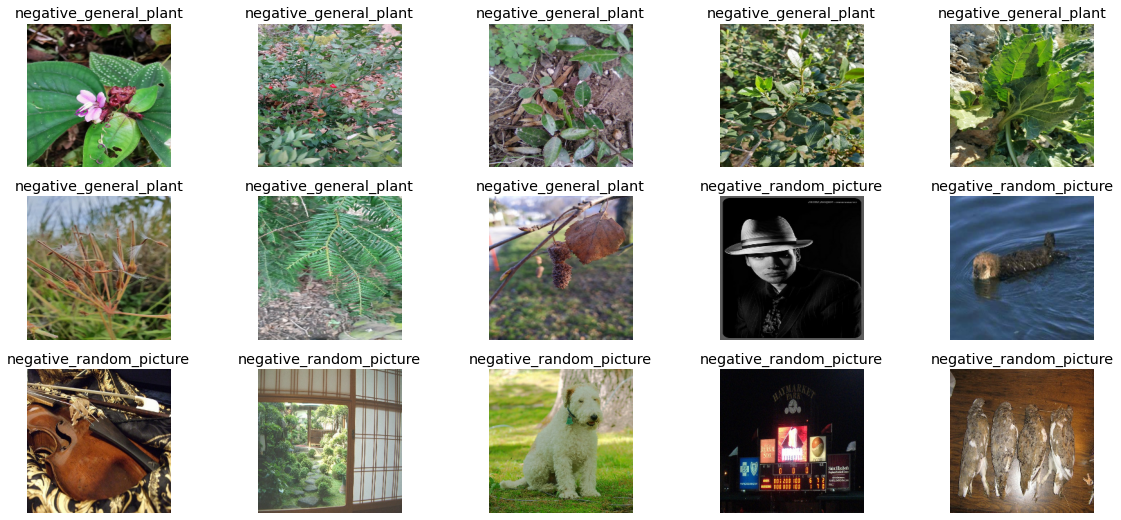

In [47]:
n_classes = len(class_names)
y_ims = 3
x_ims = 5

plt.figure(figsize=(x_ims*4, y_ims*3))
for images, labels in train_dataset.take(1):
  for i in range(y_ims*x_ims):
    ax = plt.subplot(y_ims, x_ims, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i].numpy().argmax()])
    plt.axis("off")

## Processing layers

In [48]:

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)


### Image augmentation

In [49]:
image_aug = Sequential([
    RandomFlip('horizontal'),
    RandomRotation(0.2),
    RandomZoom(0.1)
])

### Mobilenet

In [50]:
mobilenet_large = MobileNetV3Large(input_shape=input_shape,
                                   include_top=False,
                                   weights='imagenet',
                                   pooling='avg',
                                   include_preprocessing=True,
                                   dropout_rate=dropout_rate)

mobilenet_large.trainable = False
mobilenet_large.summary()

Model: "MobilenetV3large"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling_1 (Rescaling)         (None, 224, 224, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
Conv (Conv2D)                   (None, 112, 112, 16) 432         rescaling_1[0][0]                
__________________________________________________________________________________________________
Conv/BatchNorm (BatchNormalizat (None, 112, 112, 16) 64          Conv[0][0]                       
___________________________________________________________________________________

In [51]:
def build_model(mobilenet):
    inputs = Input(shape=input_shape)
    x = image_aug(inputs)
    x = mobilenet(x, training=False)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.2)(x)
    outputs = Dense(n_classes, activation='softmax')(x)
    
    return(Model(inputs, outputs))
    

In [52]:
model = build_model(mobilenet_large)

In [53]:
model.compile(optimizer=Adam(learning_rate=learning_rates['top_layer']),
              loss=CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [54]:
early_stopping = EarlyStopping(patience=10, restore_best_weights=False)
reduce_lr = ReduceLROnPlateau(patience=3, factor=1./3.)
callbacks = [early_stopping, reduce_lr]

In [55]:
kwargs = {
    'epochs': epochs['top_layer'],
    'callbacks': callbacks
}
if ds_config['has_val']:
    kwargs['validation_data'] = val_dataset

history = model.fit(train_dataset, **kwargs)

Epoch 1/500
10/10 [==============================] - 5s 172ms/step - loss: 1.6630 - accuracy: 0.2562 - val_loss: 1.2745 - val_accuracy: 0.4000
Epoch 2/500
10/10 [==============================] - 1s 69ms/step - loss: 1.2381 - accuracy: 0.4437 - val_loss: 1.0928 - val_accuracy: 0.5250
Epoch 3/500
10/10 [==============================] - 1s 65ms/step - loss: 1.0736 - accuracy: 0.5312 - val_loss: 1.0228 - val_accuracy: 0.4750
Epoch 4/500
10/10 [==============================] - 1s 63ms/step - loss: 0.8800 - accuracy: 0.6938 - val_loss: 0.9671 - val_accuracy: 0.5250
Epoch 5/500
10/10 [==============================] - 1s 68ms/step - loss: 0.7903 - accuracy: 0.6938 - val_loss: 0.9469 - val_accuracy: 0.5750
Epoch 6/500
10/10 [==============================] - 1s 73ms/step - loss: 0.6309 - accuracy: 0.8000 - val_loss: 0.9234 - val_accuracy: 0.5750
Epoch 7/500
10/10 [==============================] - 1s 67ms/step - loss: 0.6236 - accuracy: 0.8188 - val_loss: 0.9387 - val_accuracy: 0.5500
Epoch

## Fine-tune models

In [56]:
unfreeze = int(len(mobilenet_large.layers) * fine_tune_unfreeze_frac)

print(f"Mobilenet-large: Unfreezing {unfreeze} of {len(mobilenet_large.layers)} layers")
mobilenet_large.trainable = True
for layer in mobilenet_large.layers[:-unfreeze]:
    layer.trainable = False

Mobilenet-large: Unfreezing 81 of 270 layers


In [57]:
mobilenet_large.summary()

Model: "MobilenetV3large"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling_1 (Rescaling)         (None, 224, 224, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
Conv (Conv2D)                   (None, 112, 112, 16) 432         rescaling_1[0][0]                
__________________________________________________________________________________________________
Conv/BatchNorm (BatchNormalizat (None, 112, 112, 16) 64          Conv[0][0]                       
___________________________________________________________________________________

In [58]:
model.compile(optimizer=RMSprop(learning_rate=learning_rates['fine_tuning']),
              loss=CategoricalCrossentropy(),
              metrics=['accuracy'])

In [59]:
print(len(history.epoch))

31


In [60]:
base_epochs = len(history.epoch)
history_FT = model.fit(train_dataset,
                       validation_data=val_dataset,
                       epochs=epochs['fine_tuning'] + base_epochs,
                       initial_epoch=history.epoch[-1],
                       callbacks=callbacks)

Epoch 31/531
10/10 [==============================] - 8s 205ms/step - loss: 0.2741 - accuracy: 0.9625 - val_loss: 0.8603 - val_accuracy: 0.6500
Epoch 32/531
10/10 [==============================] - 1s 98ms/step - loss: 0.2577 - accuracy: 0.9500 - val_loss: 0.8554 - val_accuracy: 0.6500
Epoch 33/531
10/10 [==============================] - 1s 94ms/step - loss: 0.2559 - accuracy: 0.9750 - val_loss: 0.8534 - val_accuracy: 0.6500
Epoch 34/531
10/10 [==============================] - 1s 105ms/step - loss: 0.2405 - accuracy: 0.9688 - val_loss: 0.8538 - val_accuracy: 0.6500
Epoch 35/531
10/10 [==============================] - 1s 112ms/step - loss: 0.2145 - accuracy: 0.9625 - val_loss: 0.8470 - val_accuracy: 0.6500
Epoch 36/531
10/10 [==============================] - 1s 99ms/step - loss: 0.2326 - accuracy: 0.9563 - val_loss: 0.8407 - val_accuracy: 0.6500
Epoch 37/531
10/10 [==============================] - 1s 101ms/step - loss: 0.2354 - accuracy: 0.9563 - val_loss: 0.8411 - val_accuracy: 0.

## Analyze history

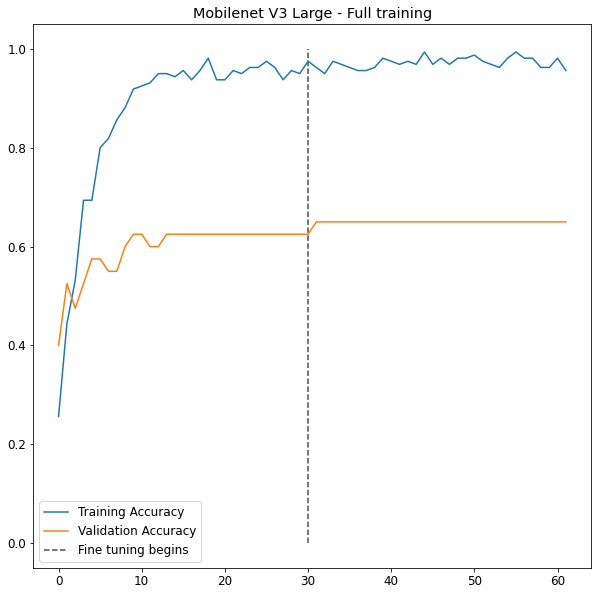

In [61]:
plt.figure(figsize=(10,10))

total_history = {}
for metric in ['accuracy', 'val_accuracy']:
    total_history[metric] = history.history[metric] + history_FT.history[metric]

ax = plt.subplot(1,1,1)
plt.plot(total_history['accuracy'], label='Training Accuracy')
plt.plot(total_history['val_accuracy'], label='Validation Accuracy')
y_min, y_max = (0, 1)
plt.vlines(base_epochs-1, ymin=y_min, ymax=y_max, label='Fine tuning begins', linestyles='--', colors=[0.3]*3)
plt.title("Mobilenet V3 Large - Full training")
plt.legend()


plt.show()

## Analyze results

In [62]:
POSITIVE = 'positive'
POSITIVE_IND = class_names.index(POSITIVE)

In [80]:
result_records = []
for split, dataset in ds_labelled.items():
    for ((imgs, class_labels), img_names) in dataset:
        probs = model.predict(imgs)
        class_values = class_labels.numpy().argmax(axis=1)
        for prob, class_val, img_name_bytes in zip(probs, class_values, img_names.numpy()):
            img_name = img_name_bytes.decode('utf-8')
            pred = prob.argmax()
            record = {'image_name': img_name,
                      'split': split,
                      'class_value': class_val,
                      'class_name': class_names[class_val],
                      'pred_val': pred,
                      'pred_probs': prob,
                      'pred_class': class_names[pred],
                      'is_positive': class_val == POSITIVE,
                      'positive_prob': prob[POSITIVE_IND],
            }
            result_records.append(record)
df_res = pd.DataFrame(result_records).set_index('image_name')
del(result_records)
df_res.head()

,split,class_value,class_name,pred_val,pred_probs,pred_class,is_positive,positive_prob
image_name,,,,,,,,
Plantnet_image-1043_species-2985994.jpg,train,0,negative_general_plant,0,"[0.9034098, 0.0022435444, 0.06595257, 0.028394...",negative_general_plant,False,0.028394
Plantnet_image-1170_species-3021496.jpg,train,0,negative_general_plant,0,"[0.8547057, 0.0020876701, 0.009738781, 0.1334679]",negative_general_plant,False,0.133468
Plantnet_image-1223_species-3189497.jpg,train,0,negative_general_plant,0,"[0.8931853, 0.0038642369, 0.03311829, 0.0698322]",negative_general_plant,False,0.069832
Plantnet_image-1249_species-2941924.jpg,train,0,negative_general_plant,0,"[0.78539836, 0.0031540997, 0.206213, 0.00523455]",negative_general_plant,False,0.005235
Plantnet_image-1405_species-8228544.jpg,train,0,negative_general_plant,0,"[0.8830867, 0.06747782, 0.04100973, 0.008425716]",negative_general_plant,False,0.008426


In [81]:
conf_matrix = (
    df_res.groupby(['class_name', 'pred_class'])['class_value']
        .count()
        .reset_index()
        .rename({'class_value': 'counts'}, axis=1)
        .pivot(index='class_name', columns='pred_class', values='counts')
        .fillna(0)
        .astype('int')
)
conf_matrix

pred_class,negative_general_plant,negative_random_picture,negative_similar_plant,positive
class_name,,,,
negative_general_plant,45,0,3,2
negative_random_picture,3,43,4,0
negative_similar_plant,2,0,44,4
positive,0,0,0,50
